# Capstone Project - The Battle of Neighborhoods

In this project, I will find out the best neighborhood in Toronto to open a new Italian Restaurant by:

Using multiple datasets from different sources (i.e. Web, Geocode, CSV files, Foursquare API), Python Webscraping using Beautifulsoup, Data Preprocessing, Data Analysis.

### Let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [2]:
df = pd.read_html ('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
table = df[0]
table

Postal Code           Borough  \
0           M1A      Not assigned   
1           M2A      Not assigned   
2           M3A        North York   
3           M4A        North York   
4           M5A  Downtown Toronto   
5           M6A        North York   
6           M7A  Downtown Toronto   
7           M8A      Not assigned   
8           M9A         Etobicoke   
9           M1B       Scarborough   
10          M2B      Not assigned   
11          M3B        North York   
12          M4B         East York   
13          M5B  Downtown Toronto   
14          M6B        North York   
15          M7B      Not assigned   
16          M8B      Not assigned   
17          M9B         Etobicoke   
18          M1C       Scarborough   
19          M2C      Not assigned   
20          M3C        North York   
21          M4C         East York   
22          M5C  Downtown Toronto   
23          M6C              York   
24          M7C      Not assigned   
25          M8C      Not assigned   
26          M9C         Etobicoke   
27          M1E       Scarborough   
28          M2E      Not assigned   
29          M3E      Not assigned   
30          M4E      East Toronto   
31          M5E  Downtown Toronto   
32          M6E              York   
33          M7E      Not assigned   
34          M8E      Not assigned   
35          M9E      Not assigned   
36          M1G       Scarborough   
37          M2G      Not assigned   
38          M3G      Not assigned   
39          M4G         East York   
40          M5G  Downtown Toronto   
41          M6G  Downtown Toronto   
42          M7G      Not assigned   
43          M8G      Not assigned   
44          M9G      Not assigned   
45          M1H       Scarborough   
46          M2H        North York   
47          M3H        North York   
48          M4H         East York   
49          M5H  Downtown Toronto   
50          M6H      West Toronto   
51          M7H      Not assigned   
52          M8H      Not assigned   
53          M9H      Not assigned   
54          M1J       Scarborough   
55          M2J        North York   
56          M3J        North York   
57          M4J         East York   
58          M5J  Downtown Toronto   
59          M6J      West Toronto   
60          M7J      Not assigned   
61          M8J      Not assigned   
62          M9J      Not assigned   
63          M1K       Scarborough   
64          M2K        North York   
65          M3K        North York   
66          M4K      East Toronto   
67          M5K  Downtown Toronto   
68          M6K      West Toronto   
69          M7K      Not assigned   
70          M8K      Not assigned   
71          M9K      Not assigned   
72          M1L       Scarborough   
73          M2L        North York   
74          M3L        North York   
75          M4L      East Toronto   
76          M5L  Downtown Toronto   
77          M6L        North York   
78          M7L      Not assigned   
79          M8L      Not assigned   
80          M9L        North York   
81          M1M       Scarborough   
82          M2M        North York   
83          M3M        North York   
84          M4M      East Toronto   
85          M5M        North York   
86          M6M              York   
87          M7M      Not assigned   
88          M8M      Not assigned   
89          M9M        North York   
90          M1N       Scarborough   
91          M2N        North York   
92          M3N        North York   
93          M4N   Central Toronto   
94          M5N   Central Toronto   
95          M6N              York   
96          M7N      Not assigned   
97          M8N      Not assigned   
98          M9N              York   
99          M1P       Scarborough   
100         M2P        North York   
101         M3P      Not assigned   
102         M4P   Central Toronto   
103         M5P   Central Toronto   
104         M6P      West Toronto   
105         M7P      Not assigned   
106         M8P      Not assigned   
107     

## Data Cleansing

In [3]:
df_dropna = table[table.Borough != 'Not assigned'].reset_index(drop=True)

df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

df = df_dropna

df.head()

PostalCode           Borough                                Neighbourhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [4]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

Borough PostalCode                      Neighbourhood
0  Central Toronto        M4N                      Lawrence Park
1  Central Toronto        M4P                   Davisville North
2  Central Toronto        M4R  North Toronto West, Lawrence Park
3  Central Toronto        M4S                         Davisville
4  Central Toronto        M4T        Moore Park, Summerhill East

In [5]:
# Check if we still have any Neighborhoods that are Not Assigned
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [Borough, PostalCode, Neighbourhood]
Index: []

In [55]:
df = df_grouped.rename(columns={'Neighbourhood':'Neighborhood'})

df.shape

(103, 3)

In [56]:
df = df[['PostalCode', 'Borough', 'Neighborhood']]

df.head()

PostalCode          Borough                       Neighborhood
0        M4N  Central Toronto                      Lawrence Park
1        M4P  Central Toronto                   Davisville North
2        M4R  Central Toronto  North Toronto West, Lawrence Park
3        M4S  Central Toronto                         Davisville
4        M4T  Central Toronto        Moore Park, Summerhill East

In [8]:
coordinates = pd.read_csv ('https://cocl.us/Geospatial_data')
coordinates

Postal Code   Latitude  Longitude
0           M1B  43.806686 -79.194353
1           M1C  43.784535 -79.160497
2           M1E  43.763573 -79.188711
3           M1G  43.770992 -79.216917
4           M1H  43.773136 -79.239476
5           M1J  43.744734 -79.239476
6           M1K  43.727929 -79.262029
7           M1L  43.711112 -79.284577
8           M1M  43.716316 -79.239476
9           M1N  43.692657 -79.264848
10          M1P  43.757410 -79.273304
11          M1R  43.750072 -79.295849
12          M1S  43.794200 -79.262029
13          M1T  43.781638 -79.304302
14          M1V  43.815252 -79.284577
15          M1W  43.799525 -79.318389
16          M1X  43.836125 -79.205636
17          M2H  43.803762 -79.363452
18          M2J  43.778517 -79.346556
19          M2K  43.786947 -79.385975
20          M2L  43.757490 -79.374714
21          M2M  43.789053 -79.408493
22          M2N  43.770120 -79.408493
23          M2P  43.752758 -79.400049
24          M2R  43.782736 -79.442259
25          M3A  43.753259 -79.329656
26          M3B  43.745906 -79.352188
27          M3C  43.725900 -79.340923
28          M3H  43.754328 -79.442259
29          M3J  43.767980 -79.487262
30          M3K  43.737473 -79.464763
31          M3L  43.739015 -79.506944
32          M3M  43.728496 -79.495697
33          M3N  43.761631 -79.520999
34          M4A  43.725882 -79.315572
35          M4B  43.706397 -79.309937
36          M4C  43.695344 -79.318389
37          M4E  43.676357 -79.293031
38          M4G  43.709060 -79.363452
39          M4H  43.705369 -79.349372
40          M4J  43.685347 -79.338106
41          M4K  43.679557 -79.352188
42          M4L  43.668999 -79.315572
43          M4M  43.659526 -79.340923
44          M4N  43.728020 -79.388790
45          M4P  43.712751 -79.390197
46          M4R  43.715383 -79.405678
47          M4S  43.704324 -79.388790
48          M4T  43.689574 -79.383160
49          M4V  43.686412 -79.400049
50          M4W  43.679563 -79.377529
51          M4X  43.667967 -79.367675
52          M4Y  43.665860 -79.383160
53          M5A  43.654260 -79.360636
54          M5B  43.657162 -79.378937
55          M5C  43.651494 -79.375418
56          M5E  43.644771 -79.373306
57          M5G  43.657952 -79.387383
58          M5H  43.650571 -79.384568
59          M5J  43.640816 -79.381752
60          M5K  43.647177 -79.381576
61          M5L  43.648198 -79.379817
62          M5M  43.733283 -79.419750
63          M5N  43.711695 -79.416936
64          M5P  43.696948 -79.411307
65          M5R  43.672710 -79.405678
66          M5S  43.662696 -79.400049
67          M5T  43.653206 -79.400049
68          M5V  43.628947 -79.394420
69          M5W  43.646435 -79.374846
70          M5X  43.648429 -79.382280
71          M6A  43.718518 -79.464763
72          M6B  43.709577 -79.445073
73          M6C  43.693781 -79.428191
74          M6E  43.689026 -79.453512
75          M6G  43.669542 -79.422564
76          M6H  43.669005 -79.442259
77          M6J  43.647927 -79.419750
78          M6K  43.636847 -79.428191
79          M6L  43.713756 -79.490074
80          M6M  43.691116 -79.476013
81          M6N  43.673185 -79.487262
82          M6P  43.661608 -79.464763
83          M6R  43.648960 -79.456325
84          M6S  43.651571 -79.484450
85          M7A  43.662301 -79.389494
86          M7R  43.636966 -79.615819
87          M7Y  43.662744 -79.321558
88          M8V  43.605647 -79.501321
89          M8W  43.602414 -79.543484
90          M8X  43.653654 -79.506944
91          M8Y  43.636258 -79.498509
92          M8Z  43.628841 -79.520999
93          M9A  43.667856 -79.532242
94          M9B  43.650943 -79.554724
95          M9C  43.643515 -79.577201
96          M9L  43.756303 -79.565963
97          M9M  43.724766 -79.532242
98          M9N  43.706876 -79.518188
99          M9P  43.696319 -79.532242
100         M9R  43.688905 -79.554724
101         M9V  43.739416 -79.588437
102         M9W  43.706748 -79.594054

In [9]:
coordinates.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
coordinates.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [10]:
# Merging the Data
df = pd.merge(df, coordinates, on='PostalCode')
df.head()

PostalCode          Borough                      Neighbourhood   Latitude  \
0        M4N  Central Toronto                      Lawrence Park  43.728020   
1        M4P  Central Toronto                   Davisville North  43.712751   
2        M4R  Central Toronto  North Toronto West, Lawrence Park  43.715383   
3        M4S  Central Toronto                         Davisville  43.704324   
4        M4T  Central Toronto        Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [57]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [12]:
df_toronto = df
df_toronto.head()

PostalCode          Borough                       Neighborhood   Latitude  \
0        M4N  Central Toronto                      Lawrence Park  43.728020   
1        M4P  Central Toronto                   Davisville North  43.712751   
2        M4R  Central Toronto  North Toronto West, Lawrence Park  43.715383   
3        M4S  Central Toronto                         Davisville  43.704324   
4        M4T  Central Toronto        Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [13]:
#Create list with the Boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [14]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165047


## Data Exploration

In [15]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [16]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [17]:
# @hidden_cell

CLIENT_ID = 'LY0FGRXGVOOSMDVHXXLOZ3PY1QO3KSLOSKPRAQDUHXVHGRBZ' # your Foursquare ID
CLIENT_SECRET = '5MUM1WHATHYCNMLQZ1HUXZNHT0W4DVTSGV2U41Y3YSK3P5S3' # your Foursquare Secret
VERSION = '20200722' # Foursquare API version

print('Credentials Stored')



Credentials Stored


In [18]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat_toronto, 
    lon_toronto, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=LY0FGRXGVOOSMDVHXXLOZ3PY1QO3KSLOSKPRAQDUHXVHGRBZ&client_secret=5MUM1WHATHYCNMLQZ1HUXZNHT0W4DVTSGV2U41Y3YSK3P5S3&v=20200722&ll=43.70460773398059,-79.39715291165047&radius=500&limit=100'

In [19]:
# Send the GET request and examine the resutls

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f1d09885f97f06b323c5bc2'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Davisville',
  'headerFullLocation': 'Davisville, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 62,
  'suggestedBounds': {'ne': {'lat': 43.70910773848059,
    'lng': -79.39093970026465},
   'sw': {'lat': 43.700107729480585, 'lng': -79.40336612303628}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c6c6c486af58cfae2ce8617',
       'name': 'Yonge Eglinton Square',
       'location': {'address': 'Yonge St.',
        'crossStreet': 'at Eglinton Ave.',
        'lat': 43.70686372150796,
        'lng': -79.39875096488025,
        'labeledLatLngs'

In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
# Now we are ready to clean the json and structure it into a pandas dataframe.

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\Moises\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


name          categories        lat  \
0                        Yonge Eglinton Square               Plaza  43.706864   
1  The Keg Steakhouse + Bar - Yonge + Eglinton          Restaurant  43.705702   
2                           Noorden Food x Bar          Restaurant  43.702814   
3                                    Starbucks         Coffee Shop  43.706859   
4                                    Balsamico  Italian Restaurant  43.701505   

         lng  
0 -79.398751  
1 -79.397905  
2 -79.397645  
3 -79.396950  
4 -79.397162

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
        

In [23]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [24]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Lawrence Park              43.728020              -79.388790   
1     Lawrence Park              43.728020              -79.388790   
2     Lawrence Park              43.728020              -79.388790   
3     Lawrence Park              43.728020              -79.388790   
4  Davisville North              43.712751              -79.390197   

                            Venue  Venue Latitude  Venue Longitude  \
0            Lawrence Park Ravine       43.726963       -79.394382   
1                  Dim Sum Deluxe       43.726953       -79.394260   
2              Zodiac Swim School       43.728532       -79.382860   
3  TTC Bus #162 - Lawrence-Donway       43.728026       -79.382805   
4         Summerhill Market North       43.715499       -79.392881   

       Venue Category  
0                Park  
1  Dim Sum Restaurant  
2         Swim School  
3            Bus Line  
4   Food & Drink Shop

In [25]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  8   
Bathurst Manor, Wilson Heights, Downsview North                        21   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      25   
Berczy Park                                                            58   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           23   
Business reply mail Processing Centre, South Ce...                     17   
CN Tower, King and Spadina, Railway Lands, Harb...                     15   
Caledonia-Fairbanks                                                     4   
Canada Post Gateway Processing Centre                                  13   
Cedarbrae                                                               8   
Central Bay Street                                                     64   
Christie                                                               17   
Church and Wellesley                                                   76   
Clarks Corners, Tam O'Shanter, Sullivan                                14   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             34   
Davisville North                                                        9   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills                                                              26   
Dorset Park, Wexford Heights, Scarborough Town ...                      6   
Downsview                                                              15   
Dufferin, Dovercourt Village                                           16   
East Toronto, Broadview North (Old East York)                           3   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           67   
First Canadian Place, Underground city                                100   
Forest Hill North & West, Forest Hill Road Park                         4   
Garden District, Ryerson                                              100   
Glencairn                                                               5   
Golden Mile, Clairlea, Oakridge                                        10   
Guildwood, Morningside, West Hill                                       8   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          25   
Hillcrest Village                                                       5   
Humber Summit                                                           1   
Humberlea, Emery                                                        2   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         21   
Kennedy Park, Ionview, East Birchmount Park                             5   
Kensington Market, Chinatown, Grange Park                              64   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                                       11   
Lawrence Park                                                           4   
Leaside                                                                34   
Little Portugal, Trinity                                               47   
Malvern, Rouge                                                          2   
Milliken, Agincourt North, Steeles East, L'Amor.

In [26]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 268 uniques categories.


In [27]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Dim Sum Restaurant' 'Swim School' 'Bus Line' 'Food & Drink Shop'
 'Breakfast Spot' 'Department Store' 'Hotel' 'Sandwich Place'
 'Gym / Fitness Center' 'Gym' 'Pizza Place' 'Yoga Studio' 'Coffee Shop'
 'Clothing Store' 'Salon / Barbershop' 'Restaurant' 'Chinese Restaurant'
 'Spa' 'Mexican Restaurant' 'Diner' 'Fast Food Restaurant'
 'Sporting Goods Shop' 'Café' 'Italian Restaurant' 'Pet Store'
 'Bagel Shop' 'Rental Car Location' 'Dessert Shop' 'Indian Restaurant'
 'Seafood Restaurant' 'Sushi Restaurant' 'Thai Restaurant' 'Brewery'
 'Toy / Game Store' 'Greek Restaurant' 'Gas Station' 'Farmers Market'
 'Gourmet Shop' 'Flower Shop' 'Pharmacy' 'Discount Store' 'Tennis Court'
 'Trail' 'Supermarket' 'Liquor Store' 'American Restaurant' 'Pub'
 'Sports Bar' 'Fried Chicken Joint' 'Bank' 'Vietnamese Restaurant'
 'Light Rail Station' 'Garden' 'Music Venue' 'Home Service'
 'Jewelry Store' 'Burger Joint' 'Vegetarian / Vegan Restaurant'
 'BBQ Joint' 'Donut Shop' 'Histo

In [28]:
"Italian Restaurant" in toronto_venues['Venue Category'].unique()

True

## Machine Learning

In [29]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2153, 269)


Neighborhoods  Accessories Store  Afghan Restaurant  Airport  \
0     Lawrence Park                  0                  0        0   
1     Lawrence Park                  0                  0        0   
2     Lawrence Park                  0                  0        0   
3     Lawrence Park                  0                  0        0   
4  Davisville North                  0                  0        0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                    0             0         0            0           0   
1                    0             0         0            0           0   
2                    0             0         0            0           0   
3                    0             0         0            0           0   
4                    0             0         0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Shop  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0          0       0           0              0          0         0   
1          0       0           0              0          0         0   
2          0       0           0              0          0         0   
3          0       0           0              0          0         0   
4          0       0           0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Pla

In [30]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(96, 269)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Lounge  \
0                0.0      0.0                 0.0             0.0   
1                0.0      0.0                 0.0             0.0   
2                0.0      0.0                 0.0             0.0   
3                0.0      0.0                 0.0             0.0   
4                0.0      0.0                 0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
0              0.0               0.0                 0.00           0.0   
1              0.0               0.0                 0.00           0.0   
2              0.0               0.0                 0.00           0.0   
3              0.0               0.0                 0.00           0.0   
4              0.0               0.0                 0.04           0.0   

   Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0       0.0          0.0         0.0                  0.0               0.0   
1       0.0          0.0         0.0                  0.0               0.0   
2       0.0          0.0         0.0                  0.0               0.0   
3       0.0          0.0         0.0                  0.0               0.0   
4       0.0          0.0         0.0                  0.0               0.0   

   Athletics & Sports  Auto Garage  Auto Workshop  BBQ Joint  Baby Store  \
0                 0.0          0.0            0.0        0.0         0.0   
1                 0.0          0.0            0.0        0.0         0.0   
2                 0.0          0.0            0.0        0.0         0.0   
3                 0.0          0.0            0.0        0.0         0.0   
4                 0.0          0.0            0.0        0.0         0.0   

   Bagel Shop  Bakery      Bank  Bar  Baseball Field  Baseball Stadium  \
0         0.0     0.0  0.000000  0.0             0.0               0.0   
1         0.0     0.0  0.000000  0.0             0.0               0.0   
2         0.0     0.0  0.095238  0.0             0.0               0.0   
3         0.0     0.0  0.250000  0.0             0.0               0.0   
4         0.0     0.0  0.000000  0.0             0.0               0.0   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Board Shop  \
0         0.0                 0.0        0.0     0.0         0.0   
1         0.0                 0.0        0.0     0.0         0.0   
2         0.0                 0.0        0.0     0.0         0.0   
3         0.0                 0.0        0.0     0.0         0.0   
4         0.0                 0.0        0.0     0.0         0.0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0            0.0        0.0       0.0                   0.0            0.25   
1            0.0        0.0       0.0                   0.0            0.00   
2            0.0        0.0       0.0                   0.0            0.00   
3            0.0        0.0       0.0                   0.0            0.00   
4            0.0        0.0       0.0                   0.0            0.00   

   Brewe

In [31]:
ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head() #.head() shows the first five rows only

Neighborhoods  Italian Restaurant
0                                        Agincourt                0.00
1                           Alderwood, Long Branch                0.00
2  Bathurst Manor, Wilson Heights, Downsview North                0.00
3                                  Bayview Village                0.00
4                Bedford Park, Lawrence Manor East                0.08

In [32]:
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

## K-Means Clustering

In [33]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighborhood'], axis=1)

In [34]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 2, 0, 2, 0, 0])

In [35]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [36]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

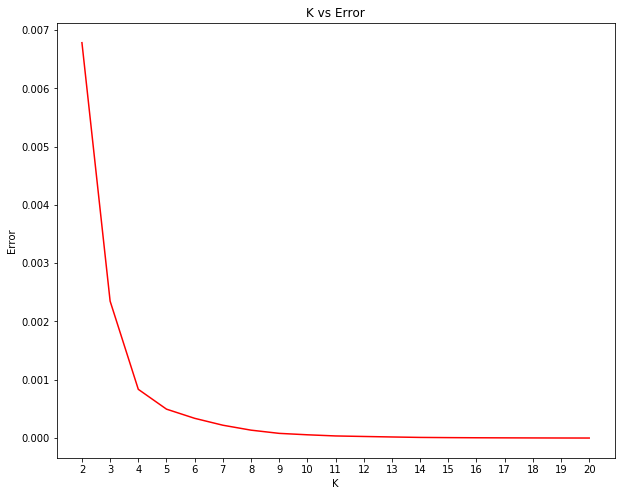

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [38]:
conda install -c districtdatalabs yellowbrick

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [39]:
from yellowbrick.cluster import KElbowVisualizer

C:\Users\Moises\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


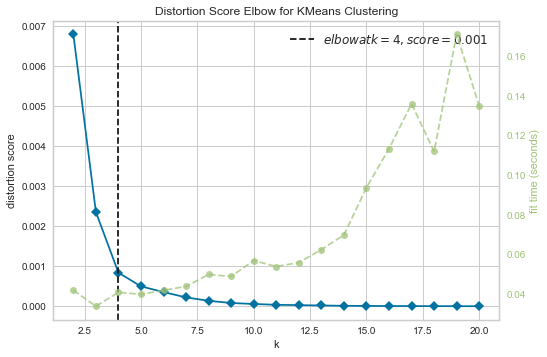

In [40]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In [41]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 3, 0, 2, 0, 0])

In [42]:

# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [43]:
to_merged.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt                0.00   
1                           Alderwood, Long Branch                0.00   
2  Bathurst Manor, Wilson Heights, Downsview North                0.00   
3                                  Bayview Village                0.00   
4                Bedford Park, Lawrence Manor East                0.08   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               1

In [45]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2153, 9)


Neighborhood  Italian Restaurant  Cluster Labels  \
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                          Twilight       43.791999       -79.258584   
0                     El Pulgarcito       43.792648       -79.259208   
0                   Commander Arena       43.794867       -79.267989   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   

              Venue Category  
0             Breakfast Spot  
0                     Lounge  
0  Latin American Restaurant  
0               Skating Rink  
1                Pizza Place

In [46]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2153, 9)


Neighborhood  Italian Restaurant  \
0                                           Agincourt            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
46                                      Lawrence Park            0.000000   
46                                      Lawrence Park            0.000000   
46                                      Lawrence Park            0.000000   
46                                      Lawrence Park            0.000000   
45                   Lawrence Manor, Lawrence Heights            0.000000   
45                   Lawrence Manor, Lawrence Heights            0.000000   
45                   Lawrence Manor, Lawrence Heights            0.000000   
45                   Lawrence Manor, Lawrence Heights            0.000000   
47                                            Leaside            0.000000   
45                   Lawrence Manor, Lawrence Heights            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
47                                            Leaside            0.000000   
45                   Lawrence Manor, Lawrence Heights            0.000000   
45                   Lawrence Manor, Lawrence Heights            0.000000   
43          Kensington Market, Chinatown, Grange Park            0.000000   
43          Kensington Market, Chinatown, Grange Park            0.000000   
43          Kensington Market, Chinatown, Grange Park            0.000000   
43          Kensington Market, Chinatown, Grange Park            0.000000   
43          Kensington Market, Chinatown, Grange Park            0.000000   
43          Kensington Market, Chinatown, Grange Park            0.000000   
43          Kensington Market, Chinatown, Grange Park            0.000000   
43          Kensington Market, Chinatown, Grange Park            0.000000   
43          Kensington Market, Chinat

In [47]:
to_merged['Venue Category'].value_counts()['Italian Restaurant']

44

In [49]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [50]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt                0.00   
1                           Alderwood, Long Branch                0.00   
2  Bathurst Manor, Wilson Heights, Downsview North                0.00   
3                                  Bayview Village                0.00   
4                Bedford Park, Lawrence Manor East                0.08   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               1

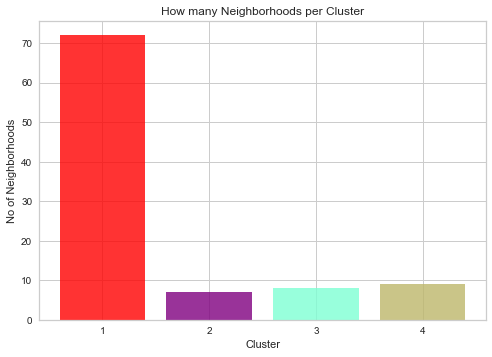

In [51]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [52]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    72
3     9
2     8
1     7
Name: Cluster Labels, dtype: int64

In [58]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                       Neighborhood
0  Central Toronto                      Lawrence Park
1  Central Toronto                   Davisville North
2  Central Toronto  North Toronto West, Lawrence Park
3  Central Toronto                         Davisville
4  Central Toronto        Moore Park, Summerhill East

In [60]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

Borough                                       Neighborhood  \
0      Central Toronto                                      Lawrence Park   
1      Central Toronto                                      Lawrence Park   
2      Central Toronto                                      Lawrence Park   
3      Central Toronto                                      Lawrence Park   
4      Central Toronto                                   Davisville North   
5      Central Toronto                                   Davisville North   
6      Central Toronto                                   Davisville North   
7      Central Toronto                                   Davisville North   
8      Central Toronto                                   Davisville North   
9      Central Toronto                                   Davisville North   
10     Central Toronto                                   Davisville North   
11     Central Toronto                                   Davisville North   
12     Central Toronto                                   Davisville North   
13     Central Toronto                        Moore Park, Summerhill East   
14     Central Toronto                        Moore Park, Summerhill East   
15     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
16     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
17     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
18     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
19     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
20     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
21     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
22     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
23     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
24     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
25     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
26     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
27     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
28     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
29     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
30     Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
31     Central Toronto                                           Roselawn   
32     Central Toronto                                           Roselawn   
33     Central Toronto                                           Roselawn   
34     Central Toronto    Forest Hill North & West, Forest Hill Road Park   
35     Central Toronto    Forest Hill North & West, Forest Hill Road Park   
36     Central Toronto    Forest Hill North & West, Forest Hill Road Park   
37     Central Toronto    Forest Hill North & West, Forest Hill Road Park   
38     Central Toronto                The Annex, North Midtown, Yorkville   
39     Central Toronto                The Annex, North Midtown, Yorkville   
40     Central Toronto                The Annex, North Midtown, Yorkville   
41     Central Toronto                The Annex, North Midtown, Yorkville   
42     Central Toronto                The Annex, North Midtown, Yorkville   
43     Central Toronto                The Annex, North Midtown, Yorkville   
44     Central Toronto                The Annex, North Midtown, Yorkville   
45     Central Toronto                The Annex, North Midtown, Yorkville   
46     Central Toronto                The Annex, North Midtown, Yorkville   
47     Central Toronto                The Annex, North Midtown, Yorkville   
48     Central Toronto                The Annex, North Midtown, Yorkville   
49     Central Toronto                The Annex, North Midtown, Yorkville   
50     Central Toronto                The Annex, North Midtown, Yorkville   
51     Cent

In [62]:

# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.sort_values(["Italian Restaurant"], ascending=False)

Borough                             Neighborhood  \
158        North York        Bedford Park, Lawrence Manor East   
181        North York        Bedford Park, Lawrence Manor East   
179        North York        Bedford Park, Lawrence Manor East   
178        North York        Bedford Park, Lawrence Manor East   
159        North York        Bedford Park, Lawrence Manor East   
160        North York        Bedford Park, Lawrence Manor East   
161        North York        Bedford Park, Lawrence Manor East   
162        North York        Bedford Park, Lawrence Manor East   
163        North York        Bedford Park, Lawrence Manor East   
164        North York        Bedford Park, Lawrence Manor East   
165        North York        Bedford Park, Lawrence Manor East   
166        North York        Bedford Park, Lawrence Manor East   
167        North York        Bedford Park, Lawrence Manor East   
168        North York        Bedford Park, Lawrence Manor East   
169        North York        Bedford Park, Lawrence Manor East   
170        North York        Bedford Park, Lawrence Manor East   
171        North York        Bedford Park, Lawrence Manor East   
172        North York        Bedford Park, Lawrence Manor East   
173        North York        Bedford Park, Lawrence Manor East   
174        North York        Bedford Park, Lawrence Manor East   
175        North York        Bedford Park, Lawrence Manor East   
180        North York        Bedford Park, Lawrence Manor East   
177        North York        Bedford Park, Lawrence Manor East   
176        North York        Bedford Park, Lawrence Manor East   
157        North York        Bedford Park, Lawrence Manor East   
147      East Toronto             The Danforth West, Riverdale   
117      East Toronto             The Danforth West, Riverdale   
116      East Toronto             The Danforth West, Riverdale   
115      East Toronto             The Danforth West, Riverdale   
142      East Toronto             The Danforth West, Riverdale   
143      East Toronto             The Danforth West, Riverdale   
144      East Toronto             The Danforth West, Riverdale   
145      East Toronto             The Danforth West, Riverdale   
146      East Toronto             The Danforth West, Riverdale   
148      East Toronto             The Danforth West, Riverdale   
135      East Toronto             The Danforth West, Riverdale   
149      East Toronto             The Danforth West, Riverdale   
150      East Toronto             The Danforth West, Riverdale   
151      East Toronto             The Danforth West, Riverdale   
152      East Toronto             The Danforth West, Riverdale   
153      East Toronto             The Danforth West, Riverdale   
154      East Toronto             The Danforth West, Riverdale   
155      East Toronto             The Danforth West, Riverdale   
156      East Toronto             The Danforth West, Riverdale   
118      East Toronto             The Danforth West, Riverdale   
136      East Toronto             The Danforth West, Riverdale   
120      East Toronto             The Danforth West, Riverdale   
141      East Toronto             The Danforth West, Riverdale   
134      East Toronto             The Danforth West, Riverdale   
133      East Toronto             The Danforth West, Riverdale   
132      East Toronto             The Danforth West, Riverdale   
131      East Toronto             The Danforth West, Riverdale   
137      East Toronto             The Danforth West, Riverdale   
138      East Toronto             The Danforth West, Riverdale   
139      East Toronto             The Danforth West, Riverdale   
140      East Toronto             The Danforth West, Riverdale   
130      East Toronto             The Danforth West, Riverdale   
121      East Toronto             The Danforth West, Riverdale   
129      East Toronto             The Danforth West, Riverdale   
128      East Toronto             The Danforth West, R

In [63]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Italian Restaurant']

14

In [64]:
# Aquamarine
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

Borough                                  Neighborhood  \
0     Central Toronto             North Toronto West, Lawrence Park   
1     Central Toronto             North Toronto West, Lawrence Park   
2     Central Toronto             North Toronto West, Lawrence Park   
3     Central Toronto             North Toronto West, Lawrence Park   
4     Central Toronto             North Toronto West, Lawrence Park   
5     Central Toronto             North Toronto West, Lawrence Park   
6     Central Toronto             North Toronto West, Lawrence Park   
7     Central Toronto             North Toronto West, Lawrence Park   
8     Central Toronto             North Toronto West, Lawrence Park   
9     Central Toronto             North Toronto West, Lawrence Park   
10    Central Toronto             North Toronto West, Lawrence Park   
11    Central Toronto             North Toronto West, Lawrence Park   
12    Central Toronto             North Toronto West, Lawrence Park   
13    Central Toronto             North Toronto West, Lawrence Park   
14    Central Toronto             North Toronto West, Lawrence Park   
15    Central Toronto             North Toronto West, Lawrence Park   
16    Central Toronto             North Toronto West, Lawrence Park   
17    Central Toronto             North Toronto West, Lawrence Park   
18    Central Toronto             North Toronto West, Lawrence Park   
19    Central Toronto             North Toronto West, Lawrence Park   
20   Downtown Toronto                   St. James Town, Cabbagetown   
21   Downtown Toronto                   St. James Town, Cabbagetown   
22   Downtown Toronto                   St. James Town, Cabbagetown   
23   Downtown Toronto                   St. James Town, Cabbagetown   
24   Downtown Toronto                   St. James Town, Cabbagetown   
25   Downtown Toronto                   St. James Town, Cabbagetown   
26   Downtown Toronto                   St. James Town, Cabbagetown   
27   Downtown Toronto                   St. James Town, Cabbagetown   
28   Downtown Toronto                   St. James Town, Cabbagetown   
29   Downtown Toronto                   St. James Town, Cabbagetown   
30   Downtown Toronto                   St. James Town, Cabbagetown   
31   Downtown Toronto                   St. James Town, Cabbagetown   
32   Downtown Toronto                   St. James Town, Cabbagetown   
33   Downtown Toronto                   St. James Town, Cabbagetown   
34   Downtown Toronto                   St. James Town, Cabbagetown   
35   Downtown Toronto                   St. James Town, Cabbagetown   
36   Downtown Toronto                   St. James Town, Cabbagetown   
37   Downtown Toronto                   St. James Town, Cabbagetown   
38   Downtown Toronto                   St. James Town, Cabbagetown   
39   Downtown Toronto                   St. James Town, Cabbagetown   
40   Downtown Toronto                   St. James Town, Cabbagetown   
41   Downtown Toronto                   St. James Town, Cabbagetown   
42   Downtown Toronto                   St. James Town, Cabbagetown   
43   Downtown Toronto                   St. James Town, Cabbagetown   
44   Downtown Toronto                   St. James Town, Cabbagetown   
45   Downtown Toronto                   St. James Town, Cabbagetown   
46   Downtown Toronto                   St. James Town, Cabbagetown   
47   Downtown Toronto                   St. James Town, Cabbagetown   
48   Downtown Toronto                   St. James Town, Cabbagetown   
49   Downtown Toronto                   St. James Town, Cabbagetown   
50   Downtown Toronto                   St. James Town, Cabbagetown   
51   Downtown Toronto                   St. James Town, Cabbagetown   
52   Downtown Toronto                   St. James Town, Cabbagetown   
53   Downtown Toronto                   St. James Town, Cabbagetown   
54   Downtown Toronto                   St. James Town, Cabbagetown   
55   Downtown Toronto                 

In [65]:
# Dark Khaki
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

Borough                                       Neighborhood  \
0    Downtown Toronto                           Garden District, Ryerson   
1    Downtown Toronto                           Garden District, Ryerson   
2    Downtown Toronto                           Garden District, Ryerson   
3    Downtown Toronto                           Garden District, Ryerson   
4    Downtown Toronto                           Garden District, Ryerson   
5    Downtown Toronto                           Garden District, Ryerson   
6    Downtown Toronto                           Garden District, Ryerson   
7    Downtown Toronto                           Garden District, Ryerson   
8    Downtown Toronto                           Garden District, Ryerson   
9    Downtown Toronto                           Garden District, Ryerson   
10   Downtown Toronto                           Garden District, Ryerson   
11   Downtown Toronto                           Garden District, Ryerson   
12   Downtown Toronto                           Garden District, Ryerson   
13   Downtown Toronto                           Garden District, Ryerson   
14   Downtown Toronto                           Garden District, Ryerson   
15   Downtown Toronto                           Garden District, Ryerson   
16   Downtown Toronto                           Garden District, Ryerson   
17   Downtown Toronto                           Garden District, Ryerson   
18   Downtown Toronto                           Garden District, Ryerson   
19   Downtown Toronto                           Garden District, Ryerson   
20   Downtown Toronto                           Garden District, Ryerson   
21   Downtown Toronto                           Garden District, Ryerson   
22   Downtown Toronto                           Garden District, Ryerson   
23   Downtown Toronto                           Garden District, Ryerson   
24   Downtown Toronto                           Garden District, Ryerson   
25   Downtown Toronto                           Garden District, Ryerson   
26   Downtown Toronto                           Garden District, Ryerson   
27   Downtown Toronto                           Garden District, Ryerson   
28   Downtown Toronto                           Garden District, Ryerson   
29   Downtown Toronto                           Garden District, Ryerson   
30   Downtown Toronto                           Garden District, Ryerson   
31   Downtown Toronto                           Garden District, Ryerson   
32   Downtown Toronto                           Garden District, Ryerson   
33   Downtown Toronto                           Garden District, Ryerson   
34   Downtown Toronto                           Garden District, Ryerson   
35   Downtown Toronto                           Garden District, Ryerson   
36   Downtown Toronto                           Garden District, Ryerson   
37   Downtown Toronto                           Garden District, Ryerson   
38   Downtown Toronto                           Garden District, Ryerson   
39   Downtown Toronto                           Garden District, Ryerson   
40   Downtown Toronto                           Garden District, Ryerson   
41   Downtown Toronto                           Garden District, Ryerson   
42   Downtown Toronto                           Garden District, Ryerson   
43   Downtown Toronto                           Garden District, Ryerson   
44   Downtown Toronto                           Garden District, Ryerson   
45   Downtown Toronto                           Garden District, Ryerson   
46   Downtown Toronto                           Garden District, Ryerson   
47   Downtown Toronto                           Garden District, Ryerson   
48   Downtown Toronto                           Garden District, Ryerson   
49   Downtown Toronto                           Garden District, Ryerson   
50   Downtown Toronto                           Garden District, Ryerson   
51   Downtown Toronto                           Garden Distric

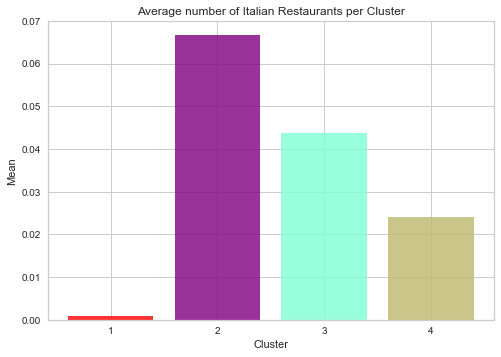

In [66]:
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                 df_cluster4['Italian Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

plt.show()

## Observations

Most of the Italian Restaurants are in cluster 2 represented by the purple clusters. The Neighborhoods located in the North York area that have the highest average of Italian Restaurants are Bedford Park and Lawrence Manor East. Even though there is a huge amount of Neighborhoods in cluster 1, there is little to no Italian Restaurant. We see that in the Downtown Toronto area (cluster 3) has the second last average of Italian Restaurants. Looking at the nearby venues, the optimum place to put a new Italian Restaurant is in Downtown Toronto as their are many Neighborhoods in the area but little to no Italian Restaurants therefore, eliminating any competition. The second best Neighborhoods that have a great oppurtunity would be in areas such as Adelaide and King, Fairview, etc which is in Cluster 1. Having 72 neighborhoods in the area with no Italian Restaurants gives a good oppurtunity for opening up a new restaurant. This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Italian restaurant in these locations with little to no competition. Nonetheless, if the food is authentic, affordable and good taste, I am confident that it will have great following everywhere